In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os
import datetime
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Functions
# Adding a target column
def generateTarget(row) :
    if row['trial_type'] == 'ADLs' :
        return 0
    if row['trial_type'] == 'Near_Falls' :
        return 0
    if row['trial_type'] == 'Falls' :
        return 1
    
# Adding a target column
def generateTarget2(row) :
    return 0

# We'll use this function to test our models from now on
def modelProcessing(X_train,y_train,X_test,y_test,model) :
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    specificity = (tn / (fp + tn))*100
    sensitivity = (tp / (tp + fn))*100
    accuracy = ((tn+tp) / (tp + tn + fp + fn))
    print("Confusion matrix : ")
    print("TN : "+str(tn) + " FP : " +str(fp))
    print("FN : "+str(fn) + " TP : " +str(tp))
    print("")
    print("Accuracy : "+str(accuracy_score(y_test,y_pred)))
    print("Recall : " +str(recall_score(y_test,y_pred)))
    print("Precision : "+str(precision_score(y_test,y_pred)))
    print("F-measure :"+str(f1_score(y_test,y_pred)))
    print("Sensitivity : "+str(sensitivity))
    print("Specificity : "+str(specificity))
    

# Obtain a DF with the metrics and bodyparts you want
def filterCols(df,metrics,bodyparts,resultants=True) :
    # Metrics are Acceleration,Magnetic and Velocity (List of strings)
    # Bodyparts are waist,l.ankle,r.ankle,l.thigh,r.thigh,sternum,head (list of strings)
    # Resultants = true will get the resultants of the respective metrics
    groupcols = ['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime']
    metriccols = []
    bodycols = []
    
    for col in df.columns.values :
        for metric in metrics :
            if (metric in col) :
                metriccols.append(col)
            if (resultants) :
                if (metric.lower() in col) :
                    metriccols.append(col)
        for part in bodyparts :
            if (part in col) :
                bodycols.append(col)
    dfOut = df[groupcols + list(set(metriccols) & set(bodycols))]
    return dfOut

In [4]:
# Load full database
dfMain = pickle.load(open("../../../dataResultants/dataset_consolidated.p", "rb"))

In [5]:
# Only run one of the following cells at a time unless your computer has enough RAM
# Used for the overlapping window preprocessing
df = dfMain.copy()
df = dfMain.drop(['target','Time','time_seconds'],axis=1)

In [5]:
# Used for the resultant peak window preprocessing
df2 = dfMain.copy()
df2 = df2.drop(['target','Time','time_seconds'],axis=1)

In [5]:
# Used for the resultant difference window preprocessing
df3 = dfMain.copy()
df3 = df3.drop(['target','Time','time_seconds'],axis=1)

In [92]:
# Used for the convolutional neural network approach
dfConv = dfMain.copy()
dfConv = dfConv.drop(['target','Time','time_seconds'],axis=1)

In [6]:
# Get the data columns and separate them based on the sensor and the feature (accel, vel and magfield)

allcols = dfMain.columns.values

groupcols = ['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime']
waistcols = []
ranklecols = []
lanklecols = []
rthighcols = []
lthighcols = []
headcols = []
sternumcols = []
accelcols = []
velcols = []
magcols = []
meancols = []
resultantcols = []
varcols = []

for col in allcols : 
    if 'r.ankle' in col :
        ranklecols.append(col)
    if 'l.ankle' in col :
        lanklecols.append(col)
    if 'waist' in col :
        waistcols.append(col)
    if 'r.thigh' in col :
        rthighcols.append(col)
    if 'l.thigh' in col :
        lthighcols.append(col)
    if 'head' in col :
        headcols.append(col)
    if 'Velocity' in col :
        velcols.append(col)
    if 'Magnetic' in col :
        magcols.append(col)
    if 'Acceleration' in col :
        accelcols.append(col)
    if 'mean' in col :
        meancols.append(col)
    if 'var' in col :
        varcols.append(col)
    if 'resultant' in col :
        resultantcols.append(col)

In [7]:
df = df.drop(resultantcols,axis=1) # Drop the resultant columns from here

In [8]:
# group in intervals of 0.5 seconds, calculating the mean
df_window_mean = df.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).mean()
df_window_mean = df_window_mean.reset_index()

# renaming the acceleration measurement columns, including a '_mean' in the end
for col in accelcols:
    df_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

for col in velcols:
    df_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)
    
for col in magcols:
    df_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

In [9]:
# group in intervals of 0.5 seconds, calculating the variance

df_window_variance = df.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).var()
df_window_variance = df_window_variance.reset_index()

# renaming the acceleration measurement columns, including a '_variance' in the end

for col in accelcols : 
    df_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    
for col in velcols : 
    df_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    
for col in magcols : 
    df_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)

In [10]:
# final dataframe, with all accelerometer columns (means and variances)
all_trials_window = pd.merge(df_window_mean, df_window_variance,on=['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime'])

# This dataframe will be used in case we decide to try different preprocessing steps
all_trials_window = all_trials_window.dropna(axis=0, how='any')

In [11]:
# Get the data columns and separate them based on the sensor and the feature (accel, vel and magfield)

allcols = all_trials_window.columns.values

groupcols = ['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original']
waistcols = []
ranklecols = []
lanklecols = []
rthighcols = []
lthighcols = []
headcols = []
sternumcols = []
accelcols = []
velcols = []
magcols = []
meancols = []
varcols = []

for col in allcols : 
    if 'r.ankle' in col :
        ranklecols.append(col)
    if 'l.ankle' in col :
        lanklecols.append(col)
    if 'waist' in col :
        waistcols.append(col)
    if 'r.thigh' in col :
        rthighcols.append(col)
    if 'l.thigh' in col :
        lthighcols.append(col)
    if 'head' in col :
        headcols.append(col)
    if 'Velocity' in col :
        velcols.append(col)
    if 'Magnetic' in col :
        magcols.append(col)
    if 'Acceleration' in col :
        accelcols.append(col)
    if 'mean' in col :
        meancols.append(col)
    if 'var' in col :
        varcols.append(col)

# 1. Overlapping windows around axis acceleration peaks
#### First we find the biggest peak in each acceleration axis (be it a maximum or minimum peak) and we create a window that spans from the smallest peak-1 second to the biggest peak + 1 second. This creates a window that takes into account all 3 peaks. 
#### We'll be using only the waist for these tests

In [ ]:
metrics = ['Acceleration','Velocity','Magnetic'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['waist'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [49]:
# Get just waist acceleration columns, time and groupcols
dfWaistAccels = filterCols(all_trials_window,[metrics],[bodyparts],True)

In [50]:

auxdf = dfWaistAccels

# Add absolute value of the acceleration means as new columns to auxdf
auxdf['AbsX'] = auxdf['waist Acceleration X (m/s^2)_mean'].abs()
auxdf['AbsY'] = auxdf['waist Acceleration Y (m/s^2)_mean'].abs()
auxdf['AbsZ'] = auxdf['waist Acceleration Z (m/s^2)_mean'].abs()

# Find the id of the rows with max absolute value for each axis
dfWaistAccels['YMax'] = auxdf.groupby(groupcols)['AbsY'].transform('idxmax')
dfWaistAccels['XMax'] = auxdf.groupby(groupcols)['AbsX'].transform('idxmax')
dfWaistAccels['ZMax'] = auxdf.groupby(groupcols)['AbsZ'].transform('idxmax')

# Find the max and min ids from the last section
dfWaistAccels['AxisMax'] = dfWaistAccels[["YMax", "XMax","ZMax"]].max(axis=1)
dfWaistAccels['AxisMin'] = dfWaistAccels[["YMax", "XMax","ZMax"]].min(axis=1)



In [51]:
# Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
dfList = []
for sub in dfWaistAccels['subject'].unique() :
    for trialtype in dfWaistAccels['trial_type'].unique() :
        for subtype in dfWaistAccels['trial_subtype'].unique() :
            for num in dfWaistAccels['trial_num'].unique() :
                aux1 = dfWaistAccels[(dfWaistAccels['subject'] == sub) & (dfWaistAccels['trial_type'] == trialtype) 
                    & (dfWaistAccels['trial_subtype'] == subtype) & (dfWaistAccels['trial_num'] == num)]
                aux2 = aux1[(aux1.index < aux1.AxisMax+4) & (aux1.index > aux1.AxisMin-4)]
                dfList.append(aux2)

fulldf = pd.concat(dfList)

In [52]:
# Dropping the columns we don't need anymore
fulldf = fulldf.drop(['XMax','ZMax','YMax','AxisMax','AxisMin','AbsX','AbsY','AbsZ'],axis=1)
    
fulldf['target'] = fulldf.apply (lambda row: generateTarget(row),axis=1)

In [53]:
y_train = fulldf[(fulldf['subject'] >= 6)]['target']
X_train = fulldf[(fulldf['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 'trial_num', 'time_datetime','target'],axis=1)
y_test = fulldf[(fulldf['subject'] < 6)]['target']
X_test = fulldf[(fulldf['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 'trial_num', 'time_datetime','target'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 3201 FP : 202
FN : 1212 TP : 522

Accuracy : 0.724742067354
Recall : 0.301038062284
Precision : 0.720994475138
F-measure :0.424735557364
Sensitivity : 30.1038062284
Specificity : 94.0640611225


###  Using only mean columns 

In [17]:
y_train = fulldf[(fulldf['subject'] >= 6)]['target']
X_train = fulldf[(fulldf['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 'trial_num', 'time_datetime','target'],axis=1)
X_train = X_train.drop(['waist Acceleration X (m/s^2)_var','waist Acceleration Y (m/s^2)_var',
                        'waist Acceleration Z (m/s^2)_var'],axis=1)
y_test = fulldf[(fulldf['subject'] < 6)]['target']
X_test = fulldf[(fulldf['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 'trial_num', 'time_datetime','target'],axis=1)
X_test = X_test.drop(['waist Acceleration X (m/s^2)_var','waist Acceleration Y (m/s^2)_var',
                        'waist Acceleration Z (m/s^2)_var'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 3343 FP : 60
FN : 1081 TP : 653

Accuracy : 0.777885925638
Recall : 0.376585928489
Precision : 0.915848527349
F-measure :0.533714752758
Sensitivity : 37.6585928489
Specificity : 98.2368498384


# 2. Resultant peak windows :

In [6]:
# group in intervals of 0.5 seconds, calculating the mean
df2_window_mean = df2.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).mean()
df2_window_mean = df2_window_mean.reset_index()

# renaming the acceleration measurement columns, including a '_mean' in the end
for col in df2.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df2_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

In [7]:
# group in intervals of 0.5 seconds, calculating the variance

df2_window_variance = df2.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='500000us')]).var()
df2_window_variance = df2_window_variance.reset_index()

# renaming the acceleration measurement columns, including a '_variance' in the end
for col in df2.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df2_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    

In [8]:
# final dataframe, with all accelerometer columns (means and variances)
df2_all_windows = pd.merge(df2_window_mean, df2_window_variance,on=['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime'])

# This dataframe will be used in case we decide to try different preprocessing steps
df2_all_windows = df2_all_windows.dropna(axis=0, how='any')

In [35]:
metrics = ['Acceleration','Velocity','Magnetic'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['waist'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [36]:
dfResWindows = filterCols(df2_all_windows,metrics,bodyparts,True)
dfResWindows['target'] = dfResWindows.apply(lambda row: generateTarget2(row),axis=1)
print(dfResWindows.columns.values)

['subject' 'trial_type' 'trial_subtype' 'trial_num' 'trial_num_original'
 'time_datetime' 'waist resultant magnetic field_mean'
 'waist Magnetic Field Z (uT)_mean' 'waist resultant angular velocity_var'
 'waist Magnetic Field Y (uT)_mean' 'waist Angular Velocity Y (rad/s)_mean'
 'waist Acceleration X (m/s^2)_mean' 'waist Acceleration X (m/s^2)_var'
 'waist Magnetic Field Y (uT)_var' 'waist Angular Velocity Z (rad/s)_mean'
 'waist resultant magnetic field_var' 'waist Acceleration Y (m/s^2)_mean'
 'waist Magnetic Field X (uT)_mean' 'waist Magnetic Field Z (uT)_var'
 'waist Acceleration Z (m/s^2)_var' 'waist Magnetic Field X (uT)_var'
 'waist resultant acceleration_mean' 'waist resultant acceleration_var'
 'waist Acceleration Z (m/s^2)_mean' 'waist Angular Velocity X (rad/s)_var'
 'waist Angular Velocity Y (rad/s)_var'
 'waist resultant angular velocity_mean'
 'waist Angular Velocity Z (rad/s)_var'
 'waist Angular Velocity X (rad/s)_mean' 'waist Acceleration Y (m/s^2)_var'
 'target']


In [37]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
df2List = []
dropRows = False # True if you want to make the dataset more balanced by only getting the window around the peak 
# of each trial as the dataset (dropping any rows outside of each trial's respective peak)
for sub in dfResWindows['subject'].unique() :
    for trialtype in dfResWindows['trial_type'].unique() :
        for subtype in dfResWindows['trial_subtype'].unique() :
            for num in dfResWindows['trial_num'].unique() :
                aux1 = dfResWindows[(dfResWindows['subject'] == sub) & 
                                         (dfResWindows['trial_type'] == trialtype) & 
                                         (dfResWindows['trial_subtype'] == subtype) & 
                                         (dfResWindows['trial_num'] == num)]
                if (aux1.shape[0] > 0) :
                    peak_index = aux1['waist resultant acceleration_mean'].idxmax()
                    if (trialtype == 'Falls') :
                        for i in range(peak_index-4,peak_index+4) : # Add the target 1 to the window
                            aux1.set_value(i, 'target', 1)
                    if (dropRows) :
                        aux2 = aux1[(aux1.index < peak_index+4) & (aux1.index >= peak_index-4)]
                        df2List.append(aux2)
                    else : 
                        df2List.append(aux1)

fulldf2 = pd.concat(df2List)

In [38]:
y_train = fulldf2[(fulldf2['subject'] >= 6)]['target']
X_train = fulldf2[(fulldf2['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

y_test = fulldf2[(fulldf2['subject'] < 6)]['target']
X_test = fulldf2[(fulldf2['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 1488 FP : 53
FN : 723 TP : 117

Accuracy : 0.67408651827
Recall : 0.139285714286
Precision : 0.688235294118
F-measure :0.231683168317
Sensitivity : 13.9285714286
Specificity : 96.5606748864


# 3. Resultant Difference Window

In [7]:
# group in intervals of 1.0 seconds, calculating the mean
df3_window_mean = df3.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='1000000us')]).mean()
df3_window_mean = df3_window_mean.reset_index()

# renaming the acceleration measurement columns, including a '_mean' in the end
for col in df3.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df3_window_mean.rename(columns={col: str(col+'_mean')}, inplace=True)

In [8]:
# group in intervals of 1.0 seconds, calculating the variance

df3_window_variance = df3.groupby(['subject','trial_type','trial_subtype','trial_num','trial_num_original',pd.Grouper(key='time_datetime', freq='1000000us')]).var()
df3_window_variance = df3_window_variance.reset_index()

# renaming the acceleration measurement columns, including a '_variance' in the end
for col in df3.columns.values :
    if ('Acceleration' in col) or ('Velocity' in col) or ('Magnetic' in col) or ('resultant' in col) :
        df3_window_variance.rename(columns={col: str(col+'_var')}, inplace=True)
    

In [9]:
# final dataframe, with all accelerometer columns (means and variances)
df3_all_windows = pd.merge(df3_window_mean, df3_window_variance,on=['subject', 'trial_type', 'trial_subtype', 'trial_num','trial_num_original','time_datetime'])

# This dataframe will be used in case we decide to try different preprocessing steps
df3_all_windows = df3_all_windows.dropna(axis=0, how='any')

In [10]:
metrics = ['Acceleration'] # 'Acceleration','Velocity and/or 'Magnetic' can be added to this list
bodyparts = ['head'] # 'waist','sternum','head','r.ankle','l.ankle','r.thigh' and/or 'l.thigh' can be added to this list

In [11]:
df3ResWindows = filterCols(df3_all_windows,metrics,bodyparts,True)
df3ResWindows['target'] = df3ResWindows.apply(lambda row: generateTarget2(row),axis=1)
print(df3ResWindows.columns.values)

['subject' 'trial_type' 'trial_subtype' 'trial_num' 'trial_num_original'
 'time_datetime' 'head Acceleration X (m/s^2)_mean'
 'head Acceleration Y (m/s^2)_var' 'head Acceleration Y (m/s^2)_mean'
 'head resultant acceleration_var' 'head Acceleration X (m/s^2)_var'
 'head Acceleration Z (m/s^2)_mean' 'head resultant acceleration_mean'
 'head Acceleration Z (m/s^2)_var' 'target']


In [12]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
df3List = []
for sub in df3ResWindows['subject'].unique() :
    for trialtype in df3ResWindows['trial_type'].unique() :
        for subtype in df3ResWindows['trial_subtype'].unique() :
            for num in df3ResWindows['trial_num'].unique() :
                aux1 = df3ResWindows[(df3ResWindows['subject'] == sub) & 
                                         (df3ResWindows['trial_type'] == trialtype) & 
                                         (df3ResWindows['trial_subtype'] == subtype) & 
                                         (df3ResWindows['trial_num'] == num)]
                aux1['resultant_diff'] = df3ResWindows['head resultant acceleration_mean'].diff().fillna(0)
                df3List.append(aux1)

df3resdiff3 = pd.concat(df3List)

In [13]:
print(df3resdiff3.columns.values)

['subject' 'trial_type' 'trial_subtype' 'trial_num' 'trial_num_original'
 'time_datetime' 'head Acceleration X (m/s^2)_mean'
 'head Acceleration Y (m/s^2)_var' 'head Acceleration Y (m/s^2)_mean'
 'head resultant acceleration_var' 'head Acceleration X (m/s^2)_var'
 'head Acceleration Z (m/s^2)_mean' 'head resultant acceleration_mean'
 'head Acceleration Z (m/s^2)_var' 'target' 'resultant_diff']


In [14]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
# This takes a while to run (about at least 10-15mins)
df3List = []
dropRows = True
for sub in df3resdiff3['subject'].unique() :
    for trialtype in df3resdiff3['trial_type'].unique() :
        for subtype in df3resdiff3['trial_subtype'].unique() :
            for num in df3resdiff3['trial_num'].unique() :
                aux1 = df3resdiff3[(df3resdiff3['subject'] == sub) & 
                                         (df3resdiff3['trial_type'] == trialtype) & 
                                         (df3resdiff3['trial_subtype'] == subtype) & 
                                         (df3resdiff3['trial_num'] == num)]
                if (aux1.shape[0] > 0) :
                    peak_index = aux1['resultant_diff'].idxmax()
                    if (trialtype == 'Falls') :
                        for i in range(peak_index-2,peak_index+2) : # Add the target 1 to the window
                            aux1.set_value(i, 'target', 1)
                    if (dropRows) :
                        aux2 = aux1[(aux1.index < peak_index+2) & (aux1.index >= peak_index-2)]
                        df3List.append(aux2) 
                    else :
                        df3List.append(aux1)

                    
fulldf3 = pd.concat(df3List)

In [15]:
y_train = fulldf3[(fulldf3['subject'] >= 6)]['target']
X_train = fulldf3[(fulldf3['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

y_test = fulldf3[(fulldf3['subject'] < 6)]['target']
X_test = fulldf3[(fulldf3['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

clf = svm.SVC(decision_function_shape='ovo', cache_size=500000, coef0=0, C=1, gamma=0.01,  class_weight=None)
modelProcessing(X_train,y_train,X_test,y_test,clf)

Confusion matrix : 
TN : 709 FP : 59
FN : 210 TP : 209

Accuracy : 0.773378264532
Recall : 0.498806682578
Precision : 0.779850746269
F-measure :0.608442503639
Sensitivity : 49.8806682578
Specificity : 92.3177083333


# 4. Convolutional Neural Networks

In [181]:
df4 = filterCols(dfConv,['Acceleration','Velocity','Magnetic'],['waist'],True)
df4['target'] = df4.apply(lambda row: generateTarget2(row),axis=1)
print(df4.columns.values)

['subject' 'trial_type' 'trial_subtype' 'trial_num' 'trial_num_original'
 'time_datetime' 'waist resultant acceleration'
 'waist resultant angular velocity' 'waist Angular Velocity Y (rad/s)'
 'waist Acceleration Y (m/s^2)' 'waist Magnetic Field X (uT)'
 'waist Acceleration Z (m/s^2)' 'waist Magnetic Field Z (uT)'
 'waist Angular Velocity Z (rad/s)' 'waist Magnetic Field Y (uT)'
 'waist Angular Velocity X (rad/s)' 'waist Acceleration X (m/s^2)'
 'waist resultant magnetic field' 'target']


In [182]:
# # Creating the window for each subject,trialtype, subtype and number and combine them all into one single dataframe
df4List = []
for sub in df4['subject'].unique() :
    for trialtype in ['Falls'] :
        for subtype in df4['trial_subtype'].unique() :
            for num in df4['trial_num'].unique() :
                aux1 = df4[(df4['subject'] == sub) & 
                                         (df4['trial_type'] == trialtype) & 
                                         (df4['trial_subtype'] == subtype) & 
                                         (df4['trial_num'] == num)]
                if (aux1.shape[0] > 0) :
                    if (trialtype == 'Falls') :
                        peak_index = aux1['waist resultant acceleration'].idxmax()
                        for i in range(peak_index-250,peak_index+250) : # Add the target 1 to the window
                            aux1.set_value(i, 'target', 1)
                    df4List.append(aux1)

fulldf4 = pd.concat(df4List)

In [183]:
y_train = fulldf4[(fulldf4['subject'] >= 6)]['target']
X_train = fulldf4[(fulldf4['subject'] >= 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

y_test = fulldf4[(fulldf4['subject'] < 6)]['target']
X_test = fulldf4[(fulldf4['subject'] < 6)].drop(['trial_num_original',
                'trial_type', 'subject', 'trial_subtype', 
                    'trial_num','target','time_datetime'],axis=1)

In [184]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D,MaxPooling1D, Flatten,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K

In [185]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [186]:
X_train_new = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_new = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [187]:
def reshapeData(X,y) :
    i = 0
    X_train_final = []
    y_train_final = []
    while i < len(X) :
        if (i+250 < len(X)) :
            elem1 = X[i:i+250]
            elem2 = y[i:i+250]
            count0 = 0
            count1 = 0
            for elem in elem2 : 
                if (elem == 0) :
                    count0 += 1
                else :
                    count1 += 1
            if ((count1 / (count0+count1)) >= 0.5) :
                y_train_final.append(1)
            else :
                y_train_final.append(0)
            X_train_final.append(elem1)
        i += 250
    return np.asarray(X_train_final),np.asarray(y_train_final)

In [188]:
X_train_final,y_train_final = reshapeData(X_train_new,y_train)
X_test_final,y_test_final = reshapeData(X_test_new,y_test)   

print(X_train_final.shape)

(806, 250, 12, 1)


In [201]:
conv = Sequential()
conv.add(Conv2D(filters=40, kernel_size=(25,1), input_shape = (250,12,1), activation = 'relu'))
conv.add(MaxPooling2D(5,5))
conv.add(Flatten())
conv.add(Dense(1, activation = 'sigmoid'))
sgd = SGD(lr = 0.001, momentum = 0.9, decay = 0, nesterov = False)
conv.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
conv.fit(X_train_final, y_train_final, batch_size = 500, epochs = 2000, verbose = 0)

In [202]:
print("Model info : ")
print("Input shape:  "+str(X_train_final.shape))
print("Conv1D Layer : ")
print("Input : " + str(conv.layers[0].input))
print("Output : "+str(conv.layers[0].output))
print("MaxPooling1D Layer : ")
print("Output : "+str(conv.layers[1].output))
print("Flatten Layer : ")
print("Output : "+str(conv.layers[2].output))
print("Dense Output Layer :")
print("Output : "+str(conv.layers[3].output))

Model info : 
Input shape:  (806, 250, 12, 1)
Conv1D Layer : 
Input : Tensor("conv2d_29_input:0", shape=(?, 250, 12, 1), dtype=float32)
Output : Tensor("conv2d_29/Relu:0", shape=(?, 226, 12, 40), dtype=float32)
MaxPooling1D Layer : 
Output : Tensor("max_pooling2d_27/MaxPool:0", shape=(?, 45, 2, 40), dtype=float32)
Flatten Layer : 
Output : Tensor("flatten_22/Reshape:0", shape=(?, ?), dtype=float32)
Dense Output Layer :
Output : Tensor("dense_22/Sigmoid:0", shape=(?, 1), dtype=float32)


In [203]:
# Looking at the output of 1 trial
# Conv1D Layer
get_layer_output1 = K.function([conv.layers[0].input],
                                  [conv.layers[0].output])
layer_output1 = get_layer_output1([X_test_final])[0]
print("Conv1D Layer : (X filters for each of the observations)")
print(layer_output1[0])

# MaxPooling1D Layer
get_layer_output2 = K.function([conv.layers[1].input],
                                  [conv.layers[1].output])
layer_output2 = get_layer_output2([layer_output1])[0]
print("MaxPooling1D Layer :")
print(layer_output2[0])
# Flatten layer
get_layer_output3 = K.function([conv.layers[2].input],
                                  [conv.layers[2].output])
layer_output3 = get_layer_output3([layer_output2])[0]
print("Flatten Layer : ")
print(layer_output3[0])
# Dense layer
get_layer_output4 = K.function([conv.layers[3].input],
                                  [conv.layers[3].output])
layer_output4 = get_layer_output4([layer_output3])[0]
print("Dense Layer : ")
print(layer_output4[0])

Conv1D Layer : (X filters for each of the observations)
[[[  0.00000000e+00   1.55483663e-01   3.43012810e+00 ...,   0.00000000e+00
     0.00000000e+00   1.15803461e+01]
  [  0.00000000e+00   2.32809149e-02   3.89818072e-01 ...,   0.00000000e+00
     0.00000000e+00   1.38937688e+00]
  [  0.00000000e+00   2.29320899e-02   3.75918329e-01 ...,   0.00000000e+00
     0.00000000e+00   1.35405648e+00]
  ..., 
  [  0.00000000e+00   2.58568116e-03   1.00844458e-01 ...,   0.00000000e+00
     0.00000000e+00   2.95735836e-01]
  [  4.69981146e+00   0.00000000e+00   0.00000000e+00 ...,   1.52977252e+00
     1.28457382e-01   0.00000000e+00]
  [  0.00000000e+00   9.22642589e-01   2.09365520e+01 ...,   0.00000000e+00
     0.00000000e+00   6.89588318e+01]]

 [[  0.00000000e+00   1.68819368e-01   3.43486500e+00 ...,   0.00000000e+00
     0.00000000e+00   1.16097088e+01]
  [  0.00000000e+00   2.62423716e-02   3.88915598e-01 ...,   0.00000000e+00
     0.00000000e+00   1.38368762e+00]
  [  0.00000000e+00   

In [204]:
metrics = conv.evaluate(X_test_final,y_test_final,verbose=0)
print("Loss : "+str(metrics[0]))
print("Accuracy : "+str(metrics[1]))

Loss : 4.17950614451
Accuracy : 0.74069478923


In [146]:
preds = conv.predict(X_test_final)

In [148]:
transformedPreds = []
for p in preds : 
    if (p >= 0.5) :
        transformedPreds.append(1) 
    else :
        transformedPreds.append(0)

In [149]:
tp,tn,fp,fn = 0,0,0,0
for i in range(len(transformedPreds)) :
    if ((transformedPreds[i] == y_test_final[i])) :
        if (transformedPreds[i] == 1) and (y_test_final[i] == 1) :
            tp += 1
        if (transformedPreds[i] == 0) and (y_test_final[i] == 0) :
            tn += 1
    else :
        if (transformedPreds[i] == 0) and (y_test_final[i] == 1) :
            fn += 1
        if (transformedPreds[i] == 1) and (y_test_final[i] == 0) :
            fp += 1

In [150]:
specificity = (tn / (fp + tn))*100
sensitivity = (tp / (tp + fn))*100
recall = (tp / (tp + fn))
precision = (tp / (tp + fp)) 
accuracy = ((tn+tp) / (tp + tn + fp + fn))
print("Confusion matrix : ")
print("TN : "+str(tn) + " FP : " +str(fp))
print("FN : "+str(fn) + " TP : " +str(tp))
print("")
print("Accuracy : "+str(accuracy))
print("Sensitivity : "+str(sensitivity))
print("Specificity : "+str(specificity))
print("Precision : "+str(precision))
print("Recall : "+str(recall))

ZeroDivisionError: division by zero

# 5. Results Visualization

In [17]:
# Uses results obtained before due to the time it takes to run the whole program multiple times
def plotRes(accL,recL,precL,specL,xticks) :
    x = np.array([i for i in range(0,len(specL))])
    ax = plt.subplot(111)
    plt.xticks(x, xticks)
    bar1 = ax.bar(x-0.2, accL,width=0.1,color='b',align='center',label='acc')
    bar2 = ax.bar(x-0.1, precL,width=0.1,color='g',align='center',label='prec')
    bar3 = ax.bar(x, recL,width=0.1,color='r',align='center',label='rec')
    bar4 = ax.bar(x+0.1, specL,width=0.1,color='y',align='center',label='spec')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[bar1,bar2,bar3,bar4],loc='upper center',bbox_to_anchor=(1.1,1.0))
    ax.set_ylim([0, 1.0])
    plt.show()

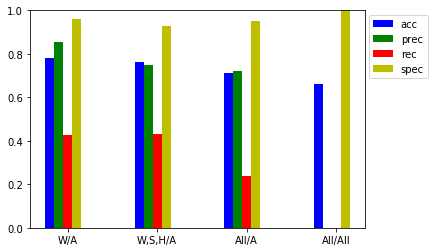

In [78]:
# Results for preprocessing 1 :
accL = np.array([0.782,0.761,0.711,0.662])
recL =  np.array([0.428,0.431,0.237,0.0])
precL = np.array([0.854,0.75,0.722,0.0])
specL = np.array([0.962,0.930,0.953,1.0])
xticks = np.array(['W/A','W,S,H/A','All/A','All/All'])
plotRes(accL,recL,precL,specL,xticks)

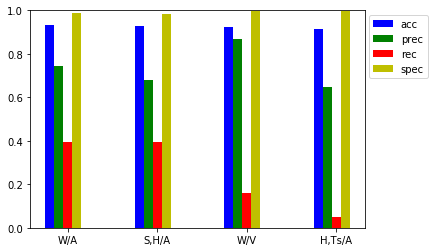

In [80]:
# Results for preprocessing 2 (without dropping rows) :
accL = np.array([0.934,0.930,0.924,0.914])
recL =  np.array([0.394,0.395,0.158,0.05])
precL = np.array([0.743,0.680,0.869,0.646])
specL = np.array([0.986,0.982,0.997,0.997])
xticks = np.array(['W/A','S,H/A','W/V','H,Ts/A'])
plotRes(accL,recL,precL,specL,xticks)

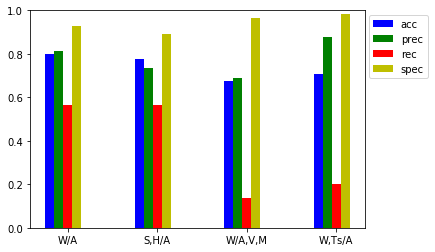

In [82]:
# Results for preprocessing 2 (dropping rows ) :
accL = np.array([0.801,0.776,0.674,0.708])
recL =  np.array([0.567,0.566,0.139,0.2])
precL = np.array([0.813,0.737,0.688,0.879])
specL = np.array([0.929,0.890,0.965,0.985])
xticks = np.array(['W/A','S,H/A','W/A,V,M','W,Ts/A'])
plotRes(accL,recL,precL,specL,xticks)

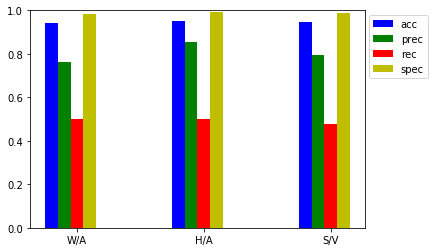

In [81]:
# Results for preprocessing 3 : (without dropping rows) 
accL = np.array([0.944,0.950,0.945])
recL =  np.array([0.5,0.502,0.477])
precL = np.array([0.763,0.854,0.796])
specL = np.array([0.985,0.992,0.988])
xticks = np.array(['W/A','H/A','S/V'])
plotRes(accL,recL,precL,specL,xticks)

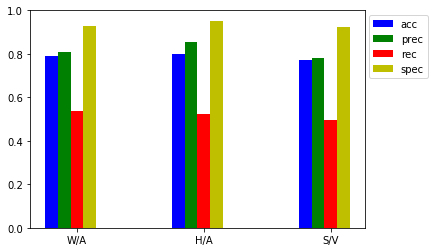

In [18]:
# Results for preprocessing 3 : (without dropping rows) 
accL = np.array([0.791,0.801,0.773])
recL =  np.array([0.538,0.523,0.498])
precL = np.array([0.807,0.856,0.779])
specL = np.array([0.929,0.952,0.923])
xticks = np.array(['W/A','H/A','S/V'])
plotRes(accL,recL,precL,specL,xticks)